# Unbuffered backtest

In [73]:
# Load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf   # falls back to sample cov below

EXCHANGE_NAME = 'binance' 

path = "C:/Users/itataurov/Desktop/ccxt_data/data_parsed/1d/technical/binance/joined/binance_perps_joined.parquet"

df = pd.read_parquet(path)
df = df.sort_values(by=['datetime'])
first_idx = df['fundingRate'].first_valid_index() # important to see when stuff began trading
df = df.loc[first_idx:]
df = df[df.datetime>'2021-01-01']
df = df[df.datetime<'2025-01-01']

In [74]:
df.columns

Index(['symbol', 'datetime', 'open', 'high', 'low', 'close', 'volume',
       'mkt_cap', 'fundingRate', 'oi', 'ls_ratio', 'longs_pct',
       'buy_volume_perp', 'total_volume_perp', 'buy_trades_perp',
       'total_trades_perp', 'spot_close', 'buy_volume_spot',
       'total_volume_spot', 'buy_trades_spot', 'total_trades_spot',
       'predicted_funding_rate'],
      dtype='object')

In [75]:
# Constants
trading_cost_rate = 15e-4

# filter backtest after filter_date
post_date = True
filter_date = '2022-01-01'

weight_inertia = 0#0.3
vol_target_bool = False
vol_target_ann=0.20
cov_lookback=90

#print parameters
print(f"Exchange: {EXCHANGE_NAME}")


Exchange: binance


In [76]:
# Signal generation
def compute_signal(df: pd.DataFrame) -> pd.DataFrame:
	lookback = 32
	df['buy_volume_perp_slowed'] = df.groupby('symbol')['buy_volume_perp'].transform(
		lambda x: x.ewm(span=lookback).mean()
	)
	df['total_volume_perp_slowed'] = df.groupby('symbol')['total_volume_perp'].transform(
		lambda x: x.ewm(span=lookback).mean()
	)
	df['signal'] = df['buy_volume_perp_slowed'] / df['total_volume_perp_slowed']

	df['signal2'] = df.groupby('symbol')['longs_pct'].transform(
		lambda x: x.ewm(span=lookback).mean()
	)

	def winsorize(x, lower_pct, upper_pct):
		lo, hi = x.quantile(lower_pct), x.quantile(upper_pct)
		return x.clip(lower=lo, upper=hi)

	df['signal'] = (
		df
		.groupby('datetime')['signal']
		.transform(lambda x: winsorize(x, 0.05, 0.95))
	)
	return df

# ── Universe filtering ──────────────────────────────────────────────────────
def filter_universe(df: pd.DataFrame) -> pd.DataFrame:
	"""
	Filter out illiquids and newly listed coins.
	"""

	df = df[df.dollar_volume_slowed >= 1e6] # at least $1M daily volume 
	df = df[df.days_since_listing >= 90] # at least 90 days since listing (need data for risk estimate)
	return df

# Utility functions
def winsorize(x):
	"""Winsorize series at 5th and 95th percentiles."""
	return np.clip(x, x.quantile(0.025), x.quantile(0.975))

# Data preparation
def prepare_data(df: pd.DataFrame) -> pd.DataFrame:
	df = df.sort_values(['datetime', 'symbol'])
	df['return'] = df.groupby('symbol')['close'].transform(lambda x: x.pct_change())

	# 1) Calculate volatility
	df['vol_expanding_window'] = (
		df.groupby('symbol')['return']
		  .transform(lambda x: x
					  .expanding(min_periods=30)
					  .std())
	)
	df['vol_ewm'] = (
		df.groupby('symbol')['return']
		  .transform(lambda x: x
					  .ewm(span=30, adjust=False, min_periods=30)
					  .std())
	)
	df['volatility'] = (
		df['vol_expanding_window'] * 0.25 +
		df['vol_ewm'] * 0.75
	)

	# 2) filter universe
	df['dollar_volume'] = df['close'] * df['volume']
	df['dollar_volume_slowed'] = (
		df.groupby('symbol')['dollar_volume']
		  .transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())
	)
	df['dv_rank'] = (
		df.groupby('datetime')['dollar_volume_slowed']
		  .rank(method='first', ascending=False)
	)
	df['dv_decile'] = df.groupby('datetime')['dollar_volume_slowed'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')) + 1

	df['market_cap_slowed'] = (
	df.groupby('symbol')['mkt_cap']
		.transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())
	)
	df['mc_rank'] = (
		df.groupby('datetime')['market_cap_slowed']
			.rank(method='first', ascending=False)
	)
	df['mc_decile'] = df.groupby('datetime')['market_cap_slowed'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')) + 1

	# 1) how many observations each symbol has accumulated up to *and incl.* the row
	df['days_since_listing'] = df.groupby('symbol').cumcount() + 1

	return df

# TODO: Add funding returns to target 
def add_prediction_target(df: pd.DataFrame) -> pd.DataFrame:
	df = df.copy()
	df = df.sort_values(['datetime'])
	# raw signal	
	df['10d_forward_price'] = df.groupby('symbol')['close'].shift(-10)
	df['10d_return'] = (df['10d_forward_price'] - df['close']) / df['close']
	# demean within each date
	df['target'] = df.groupby('datetime')['10d_return'].transform(lambda x: x - x.mean())
	return df.drop(columns=['10d_forward_price', '10d_return'])


print("Preparing data...")
df = prepare_data(df)

print("Computing signal...")
df = compute_signal(df)

print("Filtering universe...")
df = filter_universe(df)

print("Adding prediction target...")
df = add_prediction_target(df)

df


Preparing data...
Computing signal...
Filtering universe...
Adding prediction target...


,symbol,datetime,open,high,low,close,volume,mkt_cap,fundingRate,oi,...,dv_decile,market_cap_slowed,mc_rank,mc_decile,days_since_listing,buy_volume_perp_slowed,total_volume_perp_slowed,signal,signal2,target
20311,1INCH,2021-04-01,4.344400,4.533900,4.253700,4.460600,14490755.0,NaN,0.003538,NaN,...,7.0,NaN,NaN,NaN,90,1.143031e+07,2.469443e+07,0.462870,84.997705,0.099445
20381,SNX,2021-04-01,17.693000,19.431000,17.632000,19.206000,2782391.5,2.411015e+09,0.004446,NaN,...,3.0,2.347651e+09,24.0,7.0,90,9.684540e+05,2.044175e+06,0.473763,76.615812,-0.183622
20380,SKL,2021-04-01,0.752120,0.824600,0.720000,0.816680,106781335.0,4.606508e+08,0.004734,NaN,...,6.0,2.748150e+08,54.0,2.0,90,7.008064e+07,1.471926e+08,0.476115,73.315235,-0.319714
20376,RUNE,2021-04-01,7.959600,8.955000,7.957900,8.340300,8303806.0,0.000000e+00,0.002288,NaN,...,2.0,0.000000e+00,66.0,1.0,90,3.295036e+06,7.022799e+06,0.469191,68.950112,0.149518
20375,RSR,2021-04-01,0.090032,0.091795,0.084801,0.088243,467587452.0,3.706845e+08,0.004858,NaN,...,5.0,2.826469e+08,51.0,3.0,90,4.337915e+08,9.267911e+08,0.468058,77.878756,-0.195028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262969,EGLD,2024-12-31,34.301000,35.179000,33.026000,33.437000,415161.8,4.518378e+08,0.000300,9.757355e+06,...,5.0,5.006956e+08,92.0,7.0,1460,3.568184e+05,7.477575e+05,0.477185,70.668491,NaN
262968,EDU,2024-12-31,0.530400,0.545700,0.518000,0.525700,10433287.0,NaN,0.000300,5.918918e+06,...,3.0,NaN,NaN,NaN,612,1.160723e+07,2.479929e+07,0.475340,74.329599,NaN
262967,DYM,2024-12-31,1.356100,1.398800,1.300500,1.322600,5957093.4,2.548972e+08,0.000300,7.250934e+06,...,5.0,3.405120e+08,116.0,6.0,329,6.125189e+06,1.286328e+07,0.476176,77.359048,NaN
262939,CHR,2024-12-31,0.238900,0.241500,0.222700,0.232300,58700697.0,1.934000e+08,0.000283,4.443076e+06,...,4.0,2.075113e+08,148.0,5.0,1391,3.541274e+07,7.410246e+07,0.477889,69.533266,NaN


In [ ]:
import itertools
import numpy as np
import pandas as pd

def kfold_cv_metrics(X, y, k=10, random_state=42):
    """
    K-fold CV for linear OLS.
    Returns (mse, r2) averaged over folds.
    """
    n = len(y)
    if n < k:
        return np.nan, np.nan

    rng = np.random.default_rng(random_state)
    idx = np.arange(n)
    rng.shuffle(idx)
    folds = np.array_split(idx, k)

    mses, r2s = [], []
    for i in range(k):
        val_idx = folds[i]
        trn_idx = np.concatenate([folds[j] for j in range(k) if j != i])

        X_tr, y_tr = X[trn_idx], y[trn_idx]
        X_va, y_va = X[val_idx], y[val_idx]

        # Fit OLS on train
        beta = np.linalg.lstsq(X_tr, y_tr, rcond=None)[0]

        # Predict on val
        yhat = X_va @ beta
        sse = np.mean((y_va - yhat)**2)
        mses.append(sse)

        # R^2 on validation
        ybar = y_va.mean()
        sst = np.mean((y_va - ybar)**2)
        r2  = np.nan if sst == 0 else 1.0 - (sse / sst)
        r2s.append(r2)

    # Average across folds (NaN-safe for r2)
    return float(np.mean(mses)), float(np.nanmean(r2s))


def walkforward_cs_ols(df,
                       feature_cols,
                       target_col="target",
                       lookback=180,
                       horizon=10,
                       verbose=False):
    """
    Walk-forward cross-sectional OLS (multi-feature, with interactions).

    Returns
    -------
    F : DataFrame [datetime × symbol] with forecasts
    B : DataFrame [datetime × (1 + n_features)] with betas (intercept first)
    C : Series   [datetime] CV MSE estimated on each training window
    """
    # Pivot features into {feat: DataFrame}
    Xs = {f: df.pivot(index="datetime", columns="symbol", values=f) for f in feature_cols}
    Y  = df.pivot(index="datetime", columns="symbol", values=target_col)

    # Align all frames
    idx = Y.index
    cols = Y.columns
    F = pd.DataFrame(index=idx, columns=cols, dtype=float)

    # Collect betas over time: columns = ['intercept', *feature_cols]
    beta_cols = ['intercept'] + list(feature_cols)
    B = pd.DataFrame(index=idx, columns=beta_cols, dtype=float)

    # CV MSE time series
    C = pd.Series(index=idx, dtype=float)

    for di in range(lookback, len(idx)):
        start, end = di - lookback, di - horizon + 1
        train_dates = idx[start:end]

        # build stacked long-form training set
        stacked = [Xs[f].iloc[start:end].stack() for f in feature_cols]
        ys = Y.iloc[start:end].stack()
        train = pd.concat(stacked + [ys], axis=1).dropna()
        if train.empty:
            continue

        if verbose:
            print(f"Forecast date {idx[di].date()} "
                  f"→ training window {train_dates[0].date()} to {train_dates[-1].date()} "
                  f"(n = {len(train)})")

        # Design matrix
        Xmat = [np.ones(len(train))]  # intercept
        for j, f in enumerate(feature_cols):
            Xmat.append(train.iloc[:, j].values)

        Xmat = np.column_stack(Xmat)
        yvec = train.iloc[:, -1].values

        # --- NEW: CV MSE/r^2 on current training window ---
        _, C.iloc[di] = kfold_cv_metrics(Xmat, yvec, k=5, random_state=42)

        beta = np.linalg.lstsq(Xmat, yvec, rcond=None)[0]

        # store betas for this date
        B.iloc[di] = beta

        # Today's features for all symbols
        today_feats = [Xs[f].iloc[di] for f in feature_cols]
        X_today = [np.ones(len(cols))]
        for feat in today_feats:
            X_today.append(feat.values)

        X_today = np.column_stack(X_today)
        F.iloc[di] = X_today @ beta

    return F, B, C

# Create interaction term for the model
df['signalxdv_decile'] = df['signal'] * df['dv_decile']
df['signal2xdv_decile'] = df['signal2'] * df['dv_decile']

forecast, betas, cv_r2 = walkforward_cs_ols(
    df,
    feature_cols=["signal", "signal2", "dv_decile", "signalxdv_decile", "signal2xdv_decile"],
    target_col="target",
    lookback=90,
    horizon=10,
    verbose=True
)

Forecast date 2021-12-27 → training window 2021-09-28 to 2021-12-17 (n = 8010)
Forecast date 2021-12-28 → training window 2021-09-29 to 2021-12-18 (n = 8017)
Forecast date 2021-12-29 → training window 2021-09-30 to 2021-12-19 (n = 8024)
Forecast date 2021-12-30 → training window 2021-10-01 to 2021-12-20 (n = 8031)
Forecast date 2021-12-31 → training window 2021-10-02 to 2021-12-21 (n = 8038)
Forecast date 2022-01-01 → training window 2021-10-03 to 2021-12-22 (n = 8045)
Forecast date 2022-01-02 → training window 2021-10-04 to 2021-12-23 (n = 8052)
Forecast date 2022-01-03 → training window 2021-10-05 to 2021-12-24 (n = 8059)
Forecast date 2022-01-04 → training window 2021-10-06 to 2021-12-25 (n = 8067)
Forecast date 2022-01-05 → training window 2021-10-07 to 2021-12-26 (n = 8076)
Forecast date 2022-01-06 → training window 2021-10-08 to 2021-12-27 (n = 8085)
Forecast date 2022-01-07 → training window 2021-10-09 to 2021-12-28 (n = 8094)
Forecast date 2022-01-08 → training window 2021-10-1

In [102]:
import itertools
import numpy as np
import pandas as pd

def ridge_cv_alpha(X, y, k=5, alphas=None, random_state=42):
    """
    Pick ridge alpha via K-fold CV (min val MSE). Intercept (col 0) is NOT penalized.
    """
    if alphas is None:
        alphas = np.logspace(-6, 2, 25)  # tweak grid if desired

    n = len(y)
    if n < k:
        return np.nan

    rng = np.random.default_rng(random_state)
    idx = np.arange(n)
    rng.shuffle(idx)
    folds = np.array_split(idx, k)

    best_alpha, best_mse = None, np.inf
    p = X.shape[1]
    R = np.eye(p); R[0, 0] = 0.0  # no penalty on intercept

    for a in alphas:
        mses = []
        for i in range(k):
            val_idx = folds[i]
            trn_idx = np.concatenate([folds[j] for j in range(k) if j != i])

            X_tr, y_tr = X[trn_idx], y[trn_idx]
            X_va, y_va = X[val_idx], y[val_idx]

            XtX = X_tr.T @ X_tr
            Xty = X_tr.T @ y_tr
            beta = np.linalg.solve(XtX + a * R, Xty)
            yhat = X_va @ beta
            mses.append(np.mean((y_va - yhat) ** 2))

        mse = float(np.mean(mses))
        if mse < best_mse:
            best_mse, best_alpha = mse, a

    return best_alpha


def walkforward_cs_ols(df,
                       feature_cols,
                       target_col="target",
                       lookback=180,
                       horizon=10,
                       verbose=False):
    """
    Walk-forward cross-sectional Ridge (multi-feature; intercept unpenalized).

    Returns
    -------
    F : DataFrame [datetime × symbol] with forecasts
    B : DataFrame [datetime × (1 + n_features)] with betas (intercept first)
    A : Series    [datetime] selected ridge alpha (shrinkage) per date
    """
    # Pivot features into {feat: DataFrame}
    Xs = {f: df.pivot(index="datetime", columns="symbol", values=f) for f in feature_cols}
    Y  = df.pivot(index="datetime", columns="symbol", values=target_col)

    # Align all frames
    idx = Y.index
    cols = Y.columns
    F = pd.DataFrame(index=idx, columns=cols, dtype=float)

    # Collect betas over time: columns = ['intercept', *feature_cols]
    beta_cols = ['intercept'] + list(feature_cols)
    B = pd.DataFrame(index=idx, columns=beta_cols, dtype=float)

    # Shrinkage (alpha) time series
    A = pd.Series(index=idx, dtype=float)

    for di in range(lookback, len(idx)):
        start, end = di - lookback, di - horizon + 1
        train_dates = idx[start:end]

        # build stacked long-form training set
        stacked = [Xs[f].iloc[start:end].stack() for f in feature_cols]
        ys = Y.iloc[start:end].stack()
        train = pd.concat(stacked + [ys], axis=1).dropna()
        if train.empty:
            continue

        if verbose:
            print(f"Forecast date {idx[di].date()} "
                  f"→ training window {train_dates[0].date()} to {train_dates[-1].date()} "
                  f"(n = {len(train)})")

        # Design matrix with intercept (unpenalized)
        Xmat = [np.ones(len(train))]
        for j, f in enumerate(feature_cols):
            Xmat.append(train.iloc[:, j].values)
        Xmat = np.column_stack(Xmat)
        yvec = train.iloc[:, -1].values

        # --- Ridge with 5-fold CV: select alpha, then refit on full window ---
        alpha = ridge_cv_alpha(Xmat, yvec, k=5, random_state=42)
        A.iloc[di] = alpha

        p = Xmat.shape[1]
        R = np.eye(p); R[0, 0] = 0.0  # don't penalize intercept
        XtX = Xmat.T @ Xmat
        Xty = Xmat.T @ yvec
        beta = np.linalg.solve(XtX + (0.0 if np.isnan(alpha) else alpha) * R, Xty)

        # store betas for this date
        B.iloc[di] = beta

        # Today's features for all symbols
        today_feats = [Xs[f].iloc[di] for f in feature_cols]
        X_today = [np.ones(len(cols))]
        for feat in today_feats:
            X_today.append(feat.values)
        X_today = np.column_stack(X_today)

        F.iloc[di] = X_today @ beta

    return F, B, A

# interactions made outside, as you’ve been doing:
df['signalxdv_decile']  = df['signal']  * df['dv_decile']
df['signal2xdv_decile'] = df['signal2'] * df['dv_decile']

forecast, betas, ridge_alpha = walkforward_cs_ols(
    df,
    feature_cols=["signal", "signal2", "dv_decile", "signalxdv_decile", "signal2xdv_decile"],
    target_col="target",
    lookback=90,
    horizon=10,
    verbose=True
)


Forecast date 2022-03-27 → training window 2021-12-27 to 2022-03-17 (n = 8826)
Forecast date 2022-03-28 → training window 2021-12-28 to 2022-03-18 (n = 8831)
Forecast date 2022-03-29 → training window 2021-12-29 to 2022-03-19 (n = 8836)
Forecast date 2022-03-30 → training window 2021-12-30 to 2022-03-20 (n = 8841)
Forecast date 2022-03-31 → training window 2021-12-31 to 2022-03-21 (n = 8846)
Forecast date 2022-04-01 → training window 2022-01-01 to 2022-03-22 (n = 8851)
Forecast date 2022-04-02 → training window 2022-01-02 to 2022-03-23 (n = 8857)
Forecast date 2022-04-03 → training window 2022-01-03 to 2022-03-24 (n = 8863)
Forecast date 2022-04-04 → training window 2022-01-04 to 2022-03-25 (n = 8869)
Forecast date 2022-04-05 → training window 2022-01-05 to 2022-03-26 (n = 8875)
Forecast date 2022-04-06 → training window 2022-01-06 to 2022-03-27 (n = 8881)
Forecast date 2022-04-07 → training window 2022-01-07 to 2022-03-28 (n = 8887)
Forecast date 2022-04-08 → training window 2022-01-0

# Forecast Model Betas

<Axes: xlabel='datetime'>

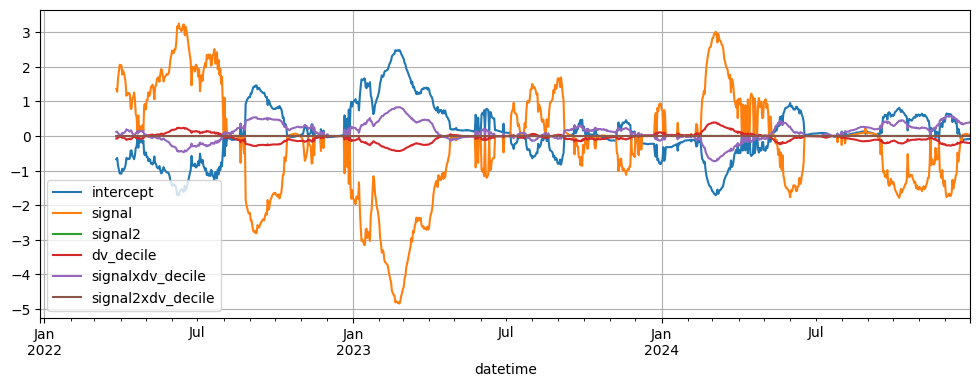

In [97]:
betas.plot(figsize=(12,4), grid=True)

In [ ]:
ridge_alpha.plot(title="Selected Ridge α over time", figsize=(10,4), grid=True)

# CV r2

<Axes: xlabel='datetime'>

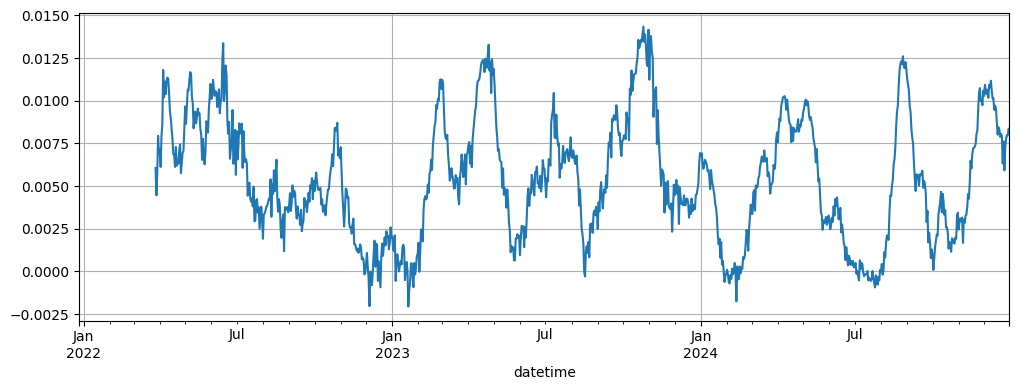

In [98]:
cv_r2.plot(figsize=(12,4), grid=True)

In [101]:
# Join forecasts back to original df
df = df.merge(forecast.stack().rename('forecast'), left_on=['datetime', 'symbol'], right_index=True)

MergeError: Passing 'suffixes' which cause duplicate columns {'forecast_x'} is not allowed.

In [91]:
# Pivot for backtest inputs
def pivot_data(df: pd.DataFrame):
	forecast = df.pivot(index='datetime', columns='symbol', values='forecast')
	returns = df.pivot(index='datetime', columns='symbol', values='return')
	funding = df.pivot(index='datetime', columns='symbol', values='fundingRate')
	volatility = df.pivot(index='datetime', columns='symbol', values='volatility')

	return forecast, returns, funding, volatility

forecast, returns, funding, volatility = pivot_data(df)

In [92]:
# TODO: Add risk scaling
def compute_weights(alpha_forecast: pd.DataFrame,
					lag: bool = True,
					inertia: float = 0.0     # 0 ≤ inertia < 1
				   ) -> pd.DataFrame:
	"""
	Convert a cross-sectional alpha signal into dollar-neutral weights.

	Parameters
	----------
	alpha_forecast : DataFrame  (index = timestamp, columns = symbol)
	lag            : bool       shift weights by one bar to avoid look-ahead
	inertia       : float      fraction of yesterday’s book to keep
					   0 → no decay (default, original behaviour)
					   0.6 → keep 60 % of prev. weights
	"""
	# 1) Demean signal
	adj = alpha_forecast.sub(alpha_forecast.mean(axis=1), axis=0)

	# 4) Dollar-neutral, |w| = 1
	weights_raw = adj.div(adj.abs().sum(axis=1), axis=0)

	# 5) Optional inertia (weight decay)
	if inertia:
		prev_w   = weights_raw.shift(1).fillna(0.0)
		weights  = inertia * prev_w + (1 - inertia) * weights_raw
	else:
		weights  = weights_raw

	# 6) Optional one-bar lag
	if lag:
		weights = weights.shift(1)

	return weights.fillna(0.0)

weights = compute_weights(forecast, lag=True)
weights

symbol,1000SATS,1INCH,1MBABYDOGE,AAVE,ACE,ACH,ADA,AEVO,AGIX,AGLD,...,XVS,YFI,YGG,ZEC,ZEN,ZETA,ZIL,ZK,ZRO,ZRX
datetime,,,,,,,,,,,,,,,,,,,,,
2021-12-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-12-28,0.000000,0.020470,0.000000,0.008160,0.000000,0.000000,0.031136,0.000000,0.0,0.000000,...,0.000000,-0.019751,0.000000,-0.013382,-0.020546,0.000000,0.000964,0.000000,0.000000,-0.011712
2021-12-29,0.000000,0.021803,0.000000,0.006168,0.000000,0.000000,0.030396,0.000000,0.0,0.000000,...,0.000000,-0.019177,0.000000,-0.016287,-0.021500,0.000000,0.001465,0.000000,0.000000,-0.011461
2021-12-30,0.000000,0.022434,0.000000,0.006990,0.000000,0.000000,0.030158,0.000000,0.0,0.000000,...,0.000000,-0.019983,0.000000,-0.016338,-0.020650,0.000000,0.001704,0.000000,0.000000,-0.012055
2021-12-31,0.000000,0.021537,0.000000,0.006709,0.000000,0.000000,0.030341,0.000000,0.0,0.000000,...,0.000000,-0.018710,0.000000,-0.018030,-0.021521,0.000000,-0.000649,0.000000,0.000000,-0.012881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,-0.000565,0.002080,0.007717,0.000939,0.003008,-0.001287,0.003722,-0.001413,0.0,0.002203,...,-0.004212,-0.004303,-0.002384,-0.005553,0.004475,0.000655,0.003308,-0.004578,-0.000994,0.002016
2024-12-28,0.000078,0.001999,0.007435,0.000085,0.003000,-0.001313,0.003188,-0.001752,0.0,0.001964,...,-0.003806,-0.004616,-0.002283,-0.007151,0.003735,0.000151,0.002990,-0.005009,-0.001271,0.001269
2024-12-29,-0.000198,0.002156,0.007075,0.000317,0.002481,-0.000713,0.002803,-0.001810,0.0,0.000598,...,-0.003589,-0.004919,-0.003163,-0.006766,0.003414,-0.000308,0.002913,-0.005085,-0.002417,0.001475


<Axes: >

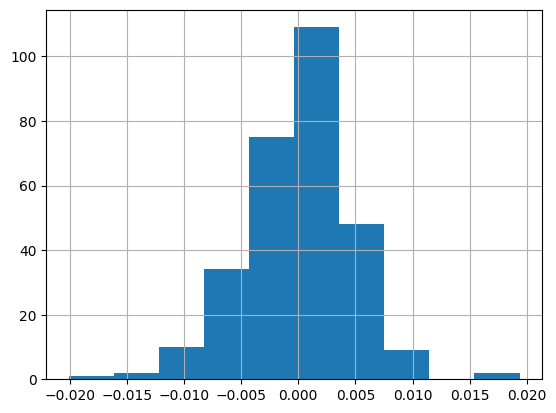

In [93]:
weights.iloc[-1].sort_values().hist()

In [94]:
# PnL and turnover calculation
def backtest(weights: pd.DataFrame,
			 returns: pd.DataFrame,
			 funding: pd.DataFrame,
			 cost_rate: float):
	weights = weights.fillna(0)
	return_pnl = (weights * returns).sum(axis=1)
	funding_pnl = -(weights * funding).sum(axis=1)
	total = return_pnl + funding_pnl
	turnover = weights.fillna(0).diff().abs().sum(axis=1)
	total_after_cost = total - cost_rate * turnover
	return return_pnl, funding_pnl, total_after_cost, turnover

rtn_pnl, fnd_pnl, tot_pnl_post_cost, turn = backtest(weights, returns, funding, trading_cost_rate)

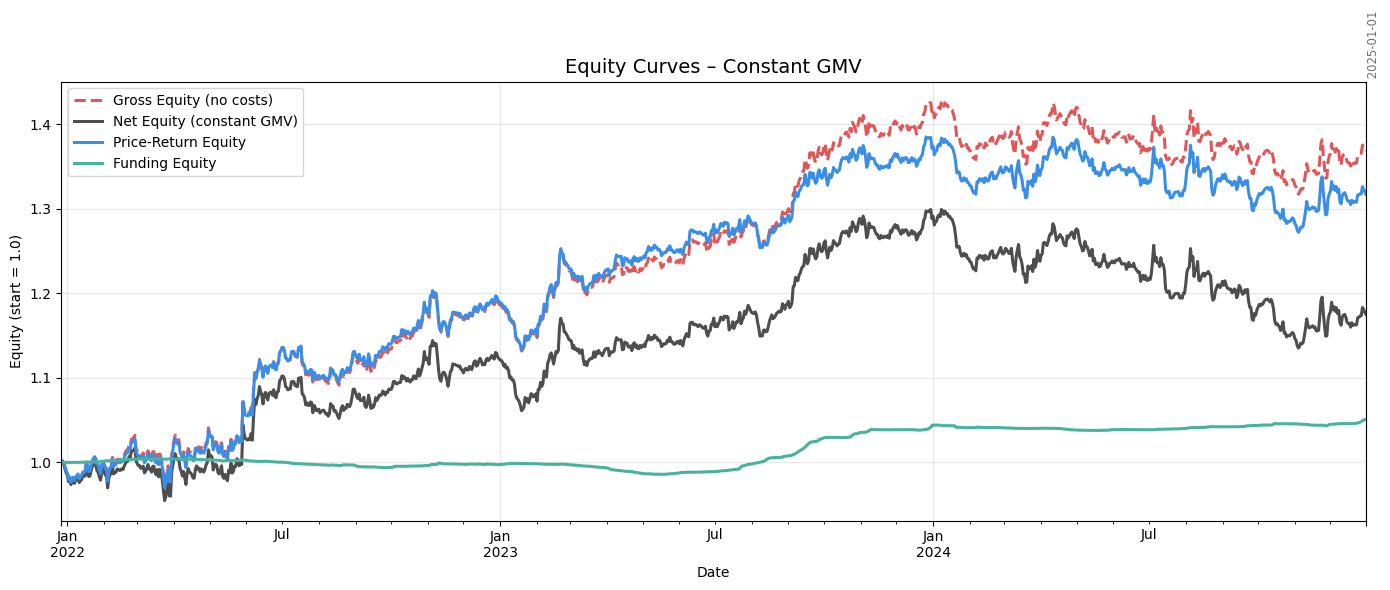

──────── Performance Summary ────────
CAGR:                            5.49%
Annualised volatility:           11.75%
Sharpe (ann.):                    0.49   95% CI [-0.70, 1.69]
Max drawdown:                  -16.40%
──────── Execution / Cost ───────────
Avg daily turnover:             11.68%
Avg holding period:               8.56 days
Average annual cost drag:       -639.26 bp


In [95]:
# ── Nicer-looking equity plot ────────────────────────────────────────────────
def plot_results(return_pnl, funding_pnl, total_after_cost, *, highlight_date="2025-01-01"):
	"""
	Plot four equity curves using a color‑blind‑friendly palette with a vertical
	reference line (default: 1 Jan 2025).

	Parameters
	----------
	return_pnl : pd.Series
		Daily price‑return P&L, indexed by date.
	funding_pnl : pd.Series
		Daily funding P&L, indexed by date.
	total_after_cost : pd.Series
		Daily total P&L after all costs, indexed by date.
	highlight_date : str or pd.Timestamp, optional
		Date at which to draw a dashed vertical reference line.  Pass ``None``
		to omit.
	"""

	# Build cumulative equity series (constant GMV, start = 1.0)
	gross_eq   = 1 + (return_pnl + funding_pnl).cumsum()
	total_eq   = 1 + total_after_cost.cumsum()
	return_eq  = 1 + return_pnl.cumsum()
	funding_eq = 1 + funding_pnl.cumsum()
	
	gross_eq.index = pd.to_datetime(gross_eq.index)
	total_eq.index = pd.to_datetime(total_eq.index)
	return_eq.index = pd.to_datetime(return_eq.index)
	funding_eq.index = pd.to_datetime(funding_eq.index)

	fig, ax = plt.subplots(figsize=(14, 6))

	# Color‑blind‑friendly hues (Okabe & Ito palette)
	palette = {
		"gross":   "#E15759",  # muted red
		"net":     "#4E4E4E",  # near‑black grey
		"return":  "#3B8EE5",  # blue
		"funding": "#47B39C",  # teal‑green
	}

	lw = 2.2  # consistent line thickness
	gross_eq.plot(ax=ax, label="Gross Equity (no costs)",   lw=lw, ls="--", color=palette["gross"])
	total_eq.plot(ax=ax, label="Net Equity (constant GMV)", lw=lw,            color=palette["net"])
	return_eq.plot(ax=ax, label="Price‑Return Equity",       lw=lw,            color=palette["return"])
	funding_eq.plot(ax=ax, label="Funding Equity",           lw=lw,            color=palette["funding"])

	# Optional vertical reference line
	if highlight_date is not None:
		highlight_date = pd.to_datetime(highlight_date)
		ax.axvline(highlight_date, lw=1.6, ls=":", color="#6F6F6F", alpha=0.85)
		# Annotate the line without cluttering the legend
		ax.text(highlight_date, ax.get_ylim()[1], highlight_date.strftime(" %Y-%m-%d"),
				va="bottom", ha="left", fontsize="small", color="#6F6F6F", rotation=90)

	ax.set_title("Equity Curves – Constant GMV", fontsize=14)
	ax.set_xlabel("Date")
	ax.set_ylabel("Equity (start = 1.0)")
	ax.legend()
	ax.grid(True, alpha=0.3)
	fig.tight_layout()
	plt.show()


# ── Expanded performance report ──────────────────────────────────────────────
def report_metrics(total_after_cost, return_pnl, turnover, cost_rate):
	"""
	Prints an extended performance summary.
	"""
	import numpy as np
	import pandas as pd

	# --- core statistics -----------------------------------------------------
	mu     = total_after_cost.mean()
	sigma  = return_pnl.std()
	sharpe = mu / sigma * np.sqrt(365)

	# 95 % CI on annualised Sharpe (Jobson & Korkie, 1981)
	n   = len(total_after_cost)
	se  = np.sqrt((1 + 0.5 * sharpe**2) * 365 / n)
	ci  = sharpe - 1.96 * se, sharpe + 1.96 * se

	# --- risk-adjusted extras -----------------------------------------------
	# annualised volatility
	vol_ann = sigma * np.sqrt(365) * 100

	# CAGR of the equity curve (constant-GMV arithmetic cum-P&L)
	equity_curve = 1 + total_after_cost.cumsum()
	cagr = equity_curve.iloc[-1]**(365 / n) - 1

	# max drawdown of cumulative P&L (not compounded)
	running_max = equity_curve.cummax()
	drawdown    = equity_curve - running_max
	max_dd      = drawdown.min()      # negative number

	# turnover & cost
	avg_turnover   = turnover.mean()
	avg_hold       = 1 / avg_turnover if avg_turnover else np.inf
	cost_pnl       = -cost_rate * turnover
	cost_drag_bps  = cost_pnl.mean() * 1e4* 365   # annual cost in bps

	# --- print nicely --------------------------------------------------------
	print("──────── Performance Summary ────────")
	print(f"CAGR:                          {cagr:7.2%}")
	print(f"Annualised volatility:         {vol_ann:7.2f}%")
	print(f"Sharpe (ann.):                 {sharpe:7.2f}   95% CI [{ci[0]:.2f}, {ci[1]:.2f}]")
	print(f"Max drawdown:                 {max_dd:8.2%}")
	print("──────── Execution / Cost ───────────")
	print(f"Avg daily turnover:            {avg_turnover:7.2%}")
	print(f"Avg holding period:            {avg_hold:7.2f} days")
	print(f"Average annual cost drag:       {cost_drag_bps:7.2f} bp")


plot_results(rtn_pnl, fnd_pnl, tot_pnl_post_cost)
report_metrics(tot_pnl_post_cost, rtn_pnl, turn, trading_cost_rate)